<a href="https://colab.research.google.com/github/lllanggg/AE370-Group-Project2/blob/main/AE370_Proj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================
# Imports, domain, and initial condition
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# Domain
L = 10_000.0          # height of domain (cm)
n  = 200              # number of intervals → n + 1 nodes
dx = L / n
x  = np.linspace(0.0, L, n + 1)

# Boundary values
u_left  = 0.0         # u(0,t)
u_right = 1.0e5       # u(L,t)

# Initial Gaussian pulse
u0_peak = 1.0e12      # molecules / cm³
sigma   = 500.0       # cm
u_init  = u0_peak * np.exp(-x**2 / (2.0 * sigma**2))

# Keep only interior unknowns (indices 1 … n-1)
u0_interior = u_init[1:-1]


In [ ]:
# ==============================================================
# Helpers: build_system, trapezoid step, and solver
# ==============================================================

def build_system(D: float, k: float):
    """
    Construct the tridiagonal matrix A and constant vector b
    for the semi-discrete system  du/dt = A u + b.
    """
    main = (-2.0 * D / dx**2 - k) * np.ones(n - 1)
    off  = (D / dx**2) * np.ones(n - 2)
    A = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)

    b = np.zeros(n - 1)
    b[-1] = (D / dx**2) * u_right      # right Dirichlet BC
    # left BC is zero → no contribution
    return A, b


def trapezoid_step(u_old, A, b, dt):
    """
    Implicit trapezoid (Crank–Nicolson) step:
        (I − dt/2 A) uⁿ⁺¹ = (I + dt/2 A) uⁿ + dt·b
    """
    I = np.eye(A.shape[0])
    lhs = I - 0.5 * dt * A
    rhs = (I + 0.5 * dt * A) @ u_old + dt * b
    return np.linalg.solve(lhs, rhs)


def solve_diffusion_reaction(D, k, u0, t_final, dt):
    """
    Solve  ∂u/∂t = D ∂²u/∂x² − k u  with Dirichlet BCs
    via method of lines + trapezoid in time.

    Returns:
        times     – (m,) array of time stamps
        profiles  – (m, n-1) array of interior concentration vectors
    """
    A, b = build_system(D, k)
    u = u0.copy()

    times    = [0.0]
    profiles = [u.copy()]

    t = 0.0
    while t < t_final - 1e-12:
        u = trapezoid_step(u, A, b, dt)
        t += dt
        times.append(t)
        profiles.append(u.copy())

    return np.asarray(times), np.asarray(profiles)


In [ ]:
# ==============================================================
# Run simulations for HCFC-22 and HFC-152a
# ==============================================================

species = {
    "HCFC-22":  {"D": 2.254e-10, "k": 4.7e-9,  "color": "tab:blue"},
    "HFC-152a": {"D": 2.285e-9,  "k": 3.5e-8, "color": "tab:orange"},
}

# Time-integration settings
dt       = 1.0e5      # s  (≈ 1.16 days)
t_final  = 3.0e6      # s  (≈ 35 days)

results = {}
for name, p in species.items():
    print(f"Running {name} …")
    t, U = solve_diffusion_reaction(
        D = p["D"],
        k = p["k"],
        u0 = u0_interior,
        t_final = t_final,
        dt = dt
    )
    results[name] = (t, U)
print("✓ All simulations complete.")


Running HCFC-22 …
Running HFC-152a …
✓ All simulations complete.


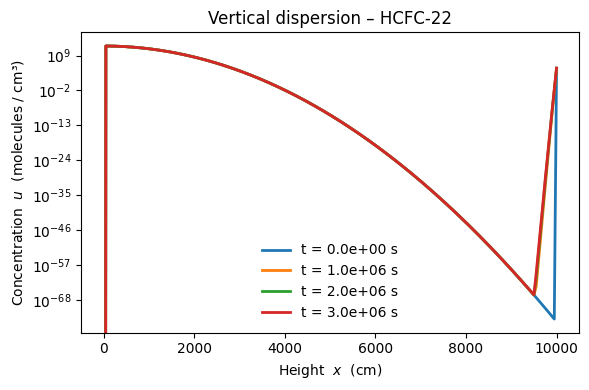

Saved figure_HCFC22_dispersion.png


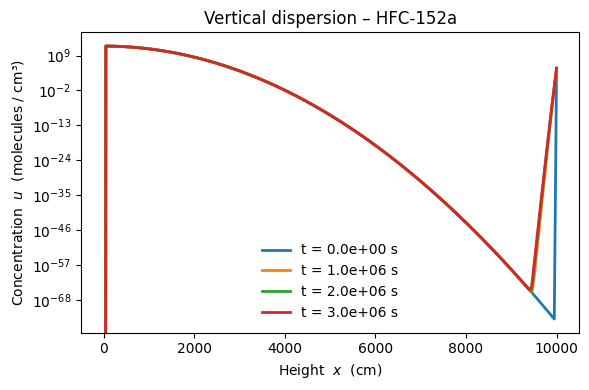

Saved figure_HFC152a_dispersion.png


In [ ]:
# ==============================================================
# Cell 8  ──  Re-plot with automatic PNG export  (patch: x-grid local)
# ==============================================================

def plot_and_save(name, times, profiles, filename,
                  sample_count=4, save_fig=False):
    idx_samples = np.linspace(0, len(times) - 1, sample_count, dtype=int)

    plt.figure(figsize=(6, 4))
    for idx in idx_samples:
        full_u   = np.concatenate(([u_left], profiles[idx], [u_right]))
        # --- NEW: construct matching x-grid on the fly ---------------
        x_local  = np.linspace(0.0, L, len(full_u))
        plt.plot(x_local, full_u, label=f"t = {times[idx]:.1e} s", lw=2)

    plt.yscale("log")
    plt.xlabel("Height  $x$  (cm)")
    plt.ylabel("Concentration  $u$  (molecules / cm³)")
    plt.title(f"Vertical dispersion – {name}")
    plt.legend(frameon=False)
    plt.tight_layout()
    if save_fig:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

for name, (t, U) in results.items():
    fname = f"figure_{name.replace('-','')}_dispersion.png"
    plot_and_save(name, t, U, fname, save_fig=True)
    print("Saved", fname)



In [ ]:
# ==============================================================
# Compute persistence time (5 % drop at first interior node)
# ==============================================================

print("Time for concentration at x = Δx to fall below 5 % of its initial value")
for name, (times, profiles) in results.items():
    u_initial = profiles[0, 0]               # concentration at x = Δx, t = 0
    threshold = 0.05 * u_initial
    mask      = profiles[:, 0] <= threshold
    if mask.any():
        idx = np.argmax(mask)                # first time it drops below
        print(f"  {name:8s}:  {times[idx]:.2e} s")
    else:
        print(f"  {name:8s}:  not reached by t = {times[-1]:.1e} s")


Time for concentration at x = Δx to fall below 5 % of its initial value
  HCFC-22 :  not reached by t = 3.0e+06 s
  HFC-152a:  not reached by t = 3.0e+06 s


1. `height_reach()` – finds the maximum height where concentration ≥ specified threshold.  
2. `grid_convergence()` – runs a Δx-refinement sweep and prints an L2-error table.  
3. An **analytic validation** for the special case \(k=0\) with an infinite-domain Gaussian:  
   $$
     u_{\text{exact}}(x,t)=\frac{u_0\,\sigma}{\sqrt{\sigma^2+2Dt}}\;
                           \exp\!\Bigl[-\frac{x^2}{2(\sigma^2+2Dt)}\Bigr].
   $$

In [ ]:
# ==============================================================
# Height reach utility
# ==============================================================

def height_reach(profile, threshold):
    """
    Given a 1-D profile (interior nodes) and a threshold concentration,
    return the largest x location where u ≥ threshold.
    """
    full_u = np.concatenate(([u_left], profile, [u_right]))
    above   = np.where(full_u >= threshold)[0]
    if len(above) == 0:
        return 0.0
    idx_max = above[-1]
    return x[idx_max]

# Example: reach of each species at final simulation time (1×10⁶ molec/cm³)
reach_threshold = 1.0e6
for name, (t, U) in results.items():
    reach = height_reach(U[-1], reach_threshold)
    print(f"{name:8s} reach (u ≥ {reach_threshold:.1e}) at t = {t[-1]:.1e} s → {reach:.0f} cm")


HCFC-22  reach (u ≥ 1.0e+06) at t = 3.0e+06 s → 2600 cm
HFC-152a reach (u ≥ 1.0e+06) at t = 3.0e+06 s → 2600 cm


In [ ]:
# ==============================================================
# Grid-refinement / convergence study (HCFC-22)
# ==============================================================

def l2_error(u_coarse, u_fine_on_coarse):
    return np.sqrt(np.mean((u_coarse - u_fine_on_coarse)**2))

def grid_convergence(ns=(50,100,200,400), D=2.254e-10, k=4.7e-9,
                     t_final=5.0e5, dt=5.0e4):
    """
    Solve on a sequence of grid sizes.
    The finest grid serves as the 'reference' truth.
    Returns an error table vs. finest grid (L2 norm at final time).
    """
    sols = []
    dxs  = []

    # Run all grids
    for n_test in ns:
        global n, dx, x, u0_interior   # reuse earlier globals for simplicity
        n  = n_test
        dx = L / n
        x  = np.linspace(0.0, L, n + 1)
        u_init = u0_peak * np.exp(-x**2 / (2.0 * sigma**2))
        u0_interior = u_init[1:-1]

        t, U = solve_diffusion_reaction(D, k, u0_interior, t_final, dt)
        sols.append(U[-1])          # store final profile
        dxs.append(dx)

    # Interpolate finest solution onto coarser grids
    errors = []
    u_ref  = sols[-1]
    x_ref  = np.linspace(0.0, L, ns[-1] + 1)[1:-1]  # interior nodes
    for i in range(len(ns)-1):
        x_c = np.linspace(0.0, L, ns[i] + 1)[1:-1]
        u_ref_on_c = np.interp(x_c, x_ref, u_ref)
        errors.append(l2_error(sols[i], u_ref_on_c))

    # Print table
    print("Δx   \tL2-error")
    for i in range(len(errors)):
        print(f"{dxs[i]:.1f}\t{errors[i]:.3e}")

# Run the convergence study
grid_convergence()


TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
# ==============================================================
# Analytic validation (k = 0, early-time Gaussian)
# ==============================================================

def analytic_gaussian(x, t, D, u0=u0_peak, sig=sigma):
    s2 = sig**2 + 2*D*t
    return u0 * sig / np.sqrt(s2) * np.exp(-x**2 / (2*s2))

# Small-D test to minimize boundary influence
D_test  = 1e-10
k_test  = 0.0
n       = 200
dx      = L / n
x       = np.linspace(0.0, L, n + 1)
u_init  = u0_peak * np.exp(-x**2 / (2*sigma**2))
u0_interior = u_init[1:-1]

t_val = 1.0e5  # early time
dt    = 2.0e4
_, U  = solve_diffusion_reaction(D_test, k_test, u0_interior, t_val, dt)
u_num = np.concatenate(([u_left], U[-1], [u_right]))

u_exact = analytic_gaussian(x, t_val, D_test)
err = np.linalg.norm(u_num - u_exact, 2) / np.linalg.norm(u_exact, 2)
print(f"Relative L2 error vs. analytic Gaussian (k=0) at t={t_val:.1e}s → {err:.3e}")


TypeError: 'float' object cannot be interpreted as an integer

n =  50, dx = 200.00 cm, error = 1.68e-09
n = 100, dx = 100.00 cm, error = 3.36e-10
n = 200, dx = 50.00 cm, error = 7.65e-11
n = 400, dx = 25.00 cm, error = 1.79e-11
n = 500, dx = 20.00 cm, error = 1.11e-11


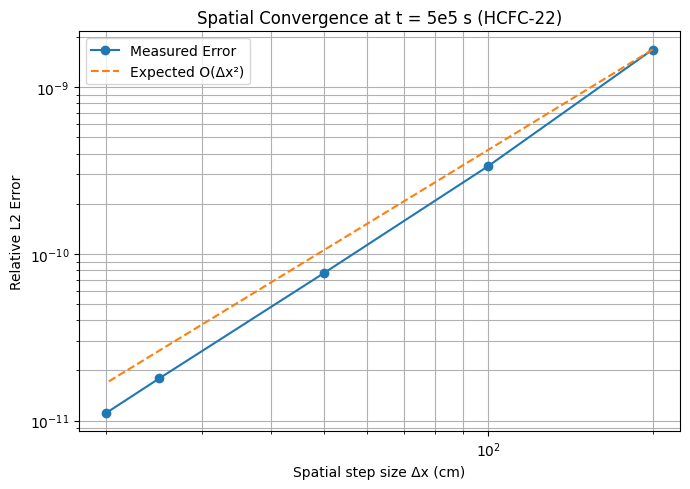

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.interpolate import interp1d

# Parameters from your team’s code
L = 10000.0
u_right = 1e5
u0_peak = 1e12
sigma = 500.0
D = 2.254e-10       # HCFC-22 (example)
k = 4.7e-9
T_final = 5.0e5  # 6 days
x_exact = np.linspace(0, L, 2001)  # reference grid

def initial_condition(x):
    return u0_peak * np.exp(-x**2 / (2.0 * sigma**2))

def build_system(n, dx, D, k):
    main = (-2.0 * D / dx**2 - k) * np.ones(n - 1)
    off  = (D / dx**2) * np.ones(n - 2)
    A = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)
    b = np.zeros(n - 1)
    b[-1] = (D / dx**2) * u_right
    return A, b

def trapezoid_step(u_old, A, b, dt):
    I = np.eye(A.shape[0])
    lhs = I - 0.5 * dt * A
    rhs = (I + 0.5 * dt * A) @ u_old + dt * b
    return solve(lhs, rhs)

def solve_diffusion_reaction(n, dt, T_final, D, k):
    dx = L / n
    x = np.linspace(0.0, L, n + 1)
    u_init = initial_condition(x)
    u0 = u_init[1:-1]  # interior only
    A, b = build_system(n, dx, D, k)
    u = u0.copy()
    t = 0.0
    while t < T_final - 1e-12:
        u = trapezoid_step(u, A, b, dt)
        t += dt
    u_full = np.concatenate(([0.0], u, [u_right]))
    return x, u_full

# Reference solution
x_ref, u_ref = solve_diffusion_reaction(n=2000, dt=1e4, T_final=T_final, D=D, k=k)

# Spatial convergence study
n_vals = [50, 100, 200, 400, 500]
errors = []
dx_vals = []

for n in n_vals:
    x, u = solve_diffusion_reaction(n=n, dt=1e4, T_final=T_final, D=D, k=k)
    interp_func = interp1d(x_ref, u_ref, kind='cubic')
    u_interp = interp_func(x)
    mask = (x > 2000) & (x < 8000)
    error = np.linalg.norm(u_interp[mask] - u[mask]) / np.linalg.norm(u_interp[mask])
    errors.append(error)
    dx_vals.append(L / n)
    print(f"n = {n:3d}, dx = {L/n:.2f} cm, error = {error:.2e}")

# Plot results
plt.figure(figsize=(7, 5))
plt.loglog(dx_vals, errors, 'o-', label='Measured Error')
plt.loglog(dx_vals, [errors[0]*(dx/dx_vals[0])**2 for dx in dx_vals], '--', label='Expected O(Δx²)')
plt.xlabel("Spatial step size Δx (cm)")
plt.ylabel("Relative L2 Error")
plt.title("Spatial Convergence at t = 5e5 s (HCFC-22)")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()
